# Rotational CoordConv for Lung Image Segmentation
#### Viggy Kumaresan, Danny Witt, and Connor Davis

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import pydot

# set random seed for reproducibility
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, TensorBoard
from keras.utils.vis_utils import plot_model

import tensorflow as tf



/Users/vigneshkumaresan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vigneshkumaresan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vigneshkumaresan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vigneshkumaresan/anaconda3/lib/python3.6/s

**Task**: Finding and Measuring Lungs in CT Data

https://www.kaggle.com/kmader/finding-lungs-in-ct-data

**Model Source**: https://www.kaggle.com/toregil/a-lung-u-net-in-keras/

In [2]:
# Download data to local machine and insert filepaths
IMAGE_LIB = '/Users/vigneshkumaresan/Desktop/MIDS/Medical_ML/2d_images/'
MASK_LIB = '/Users/vigneshkumaresan/Desktop/MIDS/Medical_ML/2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED=42

In [3]:
# Process and normalize images
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

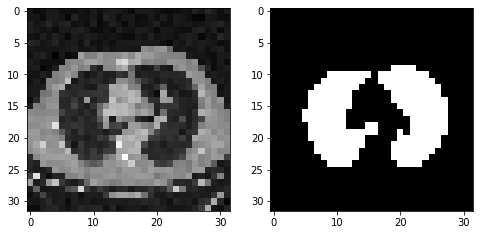

In [4]:
# Plot data and labels
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [5]:
# Split into train and validation sets
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.3)

In [6]:
# Dice coefficient will be our performance metric; commonly used in image segmentation

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [7]:
# Baseline Model
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
# Data generator
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

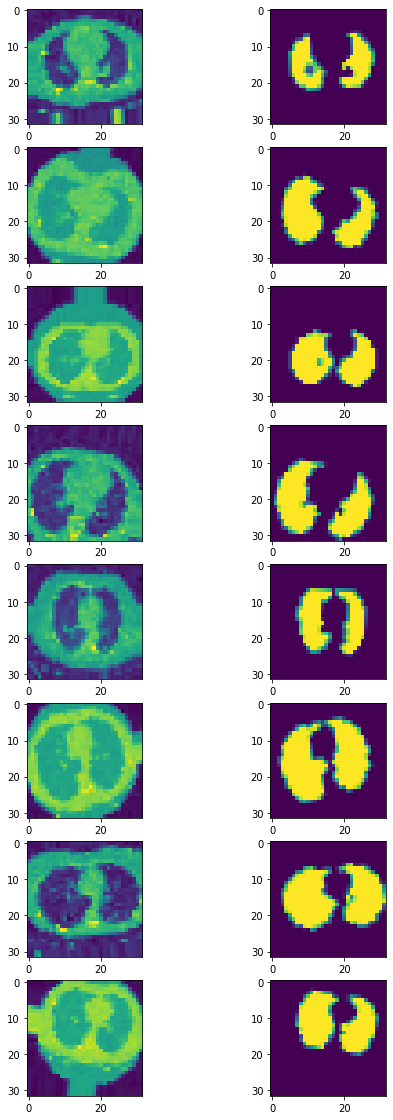

In [9]:
# Plot example images
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [10]:
# Compile and train model
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
 - 6s - loss: 0.4002 - dice_coef: 0.4199 - val_loss: 0.2230 - val_dice_coef: 0.6078
Epoch 2/10
 - 4s - loss: 0.2241 - dice_coef: 0.6575 - val_loss: 0.1435 - val_dice_coef: 0.7675
Epoch 3/10
 - 4s - loss: 0.1691 - dice_coef: 0.7665 - val_loss: 0.1183 - val_dice_coef: 0.8234
Epoch 4/10
 - 4s - loss: 0.1538 - dice_coef: 0.8009 - val_loss: 0.0959 - val_dice_coef: 0.8575
Epoch 5/10
 - 5s - loss: 0.1487 - dice_coef: 0.8144 - val_loss: 0.0961 - val_dice_coef: 0.8608
Epoch 6/10
 - 4s - loss: 0.1443 - dice_coef: 0.8207 - val_loss: 0.0904 - val_dice_coef: 0.8659
Epoch 7/10
 - 4s - loss: 0.1425 - dice_coef: 0.8245 - val_loss: 0.0864 - val_dice_coef: 0.8723
Epoch 8/10
 - 4s - loss: 0.1377 - dice_coef: 0.8305 - val_loss: 0.0898 - val_dice_coef: 0.8653
Epoch 9/10
 - 5s - loss: 0.1384 - dice_coef: 0.8308 - val_loss: 0.0857 - val_dice_coef: 0.8697
Epoch 10/10
 - 5s - loss: 0.1334 - dice_coef: 0.8

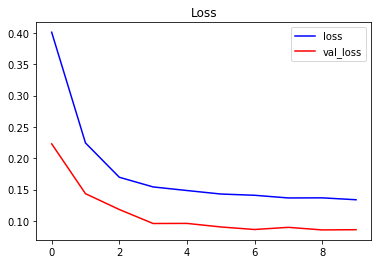

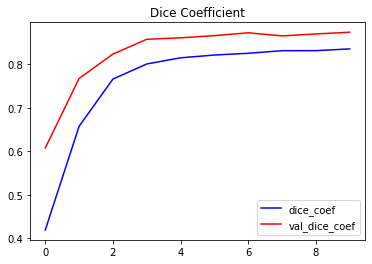

In [11]:
# Plot model performance
model.load_weights('lung.h5')

plt.plot(hist.history['loss'], color='b', label='loss')
plt.plot(hist.history['val_loss'], color='r', label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(hist.history['dice_coef'], color='b', label='dice_coef')
plt.plot(hist.history['val_dice_coef'], color='r', label='val_dice_coef')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

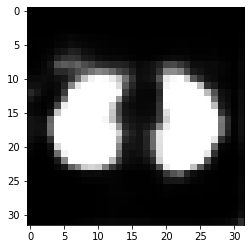

In [12]:
# Show one predicted image
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

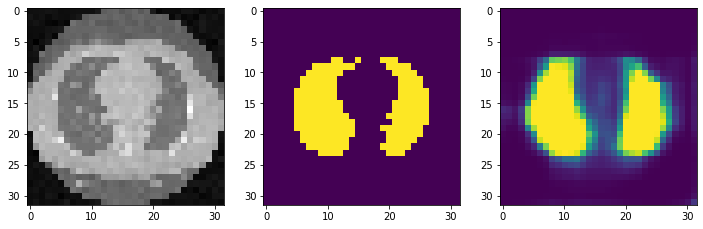

In [13]:
# plot validation and predicted images
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [14]:
# evaluate validation performance
model.evaluate(x_val, y_val)

81/81 [==============================] - 0s 384us/step


[0.22298097960007043, 0.6088784373836753]

In [15]:
# CoordConv layer implementation

class CoordConv2D(Layer):
    def __init__(self, channel, kernel, padding='valid', **kwargs):
        self.layer = Conv2D(channel, kernel, padding=padding)
        self.name = 'CoordConv2D'
        super(CoordConv2D, self).__init__(**kwargs)

    def call(self, input):
        input_shape = tf.unstack(K.shape(input))
        if K.image_data_format() == 'channel_first':
            bs, channel, w, h = input_shape
        else:
            bs, w, h, channel = input_shape

        # Get indices
        indices = tf.to_float(tf.where(K.ones([bs, w, h])))
        canvas = K.reshape(indices, [bs, w, h, 3])[..., 1:]
        
        # Normalize 
        canvas = canvas / tf.to_float(K.reshape([w, h], [1, 1, 1, 2]))
        canvas = (canvas * 2) - 1

        # Concatenate channel-wise
        input = K.concatenate([input, canvas], -1)
        return self.layer(input)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

Instructions for updating:
Use `tf.cast` instead.


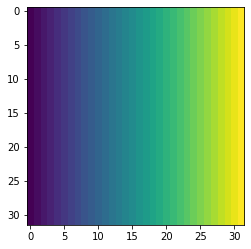

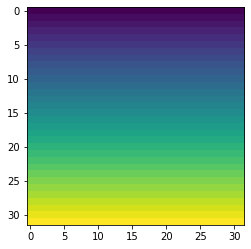

In [16]:
#Check coordconv layers:
input_shape = x_train.shape
bs, w, h, channel = input_shape
indices = tf.to_float(tf.where(K.ones([bs, w, h])))
canvas = K.reshape(indices, [bs, w, h, 3])[..., 1:]

canvas = canvas / tf.to_float(K.reshape([w, h], [1, 1, 1, 2]))
canvas = (canvas * 2) - 1

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    x_channel = canvas[0,:,:,1].eval()
    y_channel = canvas[0,:,:,0].eval()

plt.imshow(x_channel)
plt.show()
plt.imshow(y_channel)
plt.show()

In [17]:
# CoordConv model
input_layer = Input(shape=x_train.shape[1:])
#Apply coordconv layer
coordconv_layer = CoordConv2D(64, 3, padding='same')
coord = coordconv_layer(input_layer)
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(coord)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model_coord = Model(input_layer, output_layer)

In [18]:
model_coord.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
coord_conv2d_1 (CoordConv2D)    (None, 32, 32, 64)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 8)    4616        coord_conv2d_1[0][0]             
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 8)    0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

In [19]:
# Compile and train model
model_coord.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
weight_saver = ModelCheckpoint('lung_coord.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

hist = model_coord.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 9s - loss: 0.3295 - dice_coef: 0.5585 - val_loss: 0.1203 - val_dice_coef: 0.8254
Epoch 2/10
 - 7s - loss: 0.1698 - dice_coef: 0.7938 - val_loss: 0.0986 - val_dice_coef: 0.8548
Epoch 3/10
 - 9s - loss: 0.1472 - dice_coef: 0.8207 - val_loss: 0.0937 - val_dice_coef: 0.8627
Epoch 4/10
 - 9s - loss: 0.1404 - dice_coef: 0.8306 - val_loss: 0.0791 - val_dice_coef: 0.8860
Epoch 5/10
 - 9s - loss: 0.1392 - dice_coef: 0.8334 - val_loss: 0.0838 - val_dice_coef: 0.8791
Epoch 6/10
 - 8s - loss: 0.1362 - dice_coef: 0.8358 - val_loss: 0.0842 - val_dice_coef: 0.8770
Epoch 7/10
 - 8s - loss: 0.1358 - dice_coef: 0.8363 - val_loss: 0.0766 - val_dice_coef: 0.8860
Epoch 8/10
 - 8s - loss: 0.1309 - dice_coef: 0.8410 - val_loss: 0.0815 - val_dice_coef: 0.8767
Epoch 9/10
 - 8s - loss: 0.1326 - dice_coef: 0.8402 - val_loss: 0.0761 - val_dice_coef: 0.8840
Epoch 10/10
 - 8s - loss: 0.1272 - dice_coef: 0.8458 - val_loss: 0.0783 - val_dice_coef: 0.8840


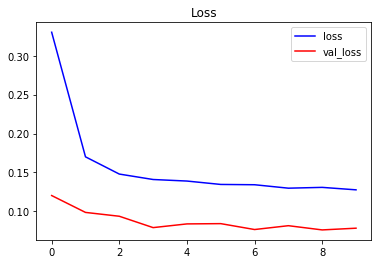

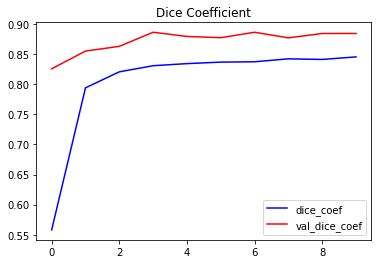

In [20]:
# Plot model performance
model_coord.load_weights('lung_coord.h5')

plt.plot(hist.history['loss'], color='b', label='loss')
plt.plot(hist.history['val_loss'], color='r', label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(hist.history['dice_coef'], color='b', label='dice_coef')
plt.plot(hist.history['val_dice_coef'], color='r', label='val_dice_coef')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

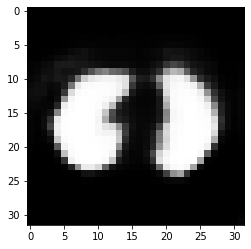

In [21]:
# Show one predicted image
plt.imshow(model_coord.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

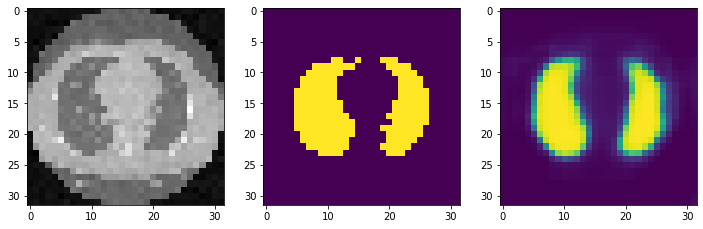

In [22]:
# plot validation and predicted images
y_hat = model_coord.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [23]:
model_coord.evaluate(x_val, y_val)

81/81 [==============================] - 0s 895us/step


[0.12028715713524524, 0.8272032642070158]

## Rotated CoordConv Layer (45 degrees)

In [24]:
# Rotated coordconv
# CoordConv rotated to 45 degrees

def deg2rad(x):
    """Converts an angle in degrees to radians."""
    return (x * np.pi) / 180

# Set rotation
degree = 45
theta = tf.to_float(np.array([
    [np.cos(deg2rad(degree)), -np.sin(deg2rad(degree)), 0], 
    [np.sin(deg2rad(degree)), np.cos(deg2rad(degree)), 0]
]))


class CoordConv2D_45(Layer):
    def __init__(self, channel, kernel, padding='valid',**kwargs):
        self.layer = Conv2D(channel, kernel, padding=padding)
        self.name = 'CoordConv2D_45'
        super(CoordConv2D_45, self).__init__(**kwargs)
        
    def call(self, input):        
        input_shape = tf.unstack(K.shape(input))
        if K.image_data_format() == 'channel_first':
            bs, channel, w, h = input_shape
        else:
            bs, w, h, channel = input_shape

        # Get indices
        indices = tf.to_float(tf.where(K.ones([bs, w, h])))
        canvas = K.reshape(indices, [bs, w, h, 3])[..., 1:]
        
        # Normalize 
        canvas = canvas / tf.to_float(K.reshape([w, h], [1, 1, 1, 2]))
        canvas = (canvas * 2) - 1
        
        # rotate
        canvas = tf.matmul(canvas, theta)

        # Concatenate channel-wise
        input = K.concatenate([input, canvas], -1)

        return self.layer(input)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

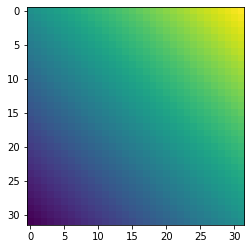

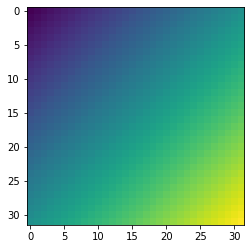

In [25]:
# Check rotated layer
degree = 45
theta = tf.to_float(np.array([
    [np.cos(deg2rad(degree)), -np.sin(deg2rad(degree)), 0], 
    [np.sin(deg2rad(degree)), np.cos(deg2rad(degree)), 0]
]))

input_shape = x_train.shape
bs, w, h, channel = input_shape
indices = tf.to_float(tf.where(K.ones([bs, w, h])))
canvas = K.reshape(indices, [bs, w, h, 3])[..., 1:]

canvas = canvas / tf.to_float(K.reshape([w, h], [1, 1, 1, 2]))
canvas = (canvas * 2) - 1
canvas = tf.matmul(canvas, theta)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    x_channel = canvas[0,:,:,1].eval()
    y_channel = canvas[0,:,:,0].eval()

plt.imshow(x_channel)
plt.show()
plt.imshow(y_channel)
plt.show()

In [26]:
input_layer = Input(shape=x_train.shape[1:])
# Apply rotated coordconv layer
coordconv_layer = CoordConv2D_45(64, 3, padding='same')
coord = coordconv_layer(input_layer)
is_weight = Input(shape=(1,), name='is_weight')
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(coord)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model_coord_rot = Model(input_layer, output_layer)

In [27]:
model_coord_rot.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
coord_conv2d_45_1 (CoordConv2D_ (None, 32, 32, 64)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 8)    4616        coord_conv2d_45_1[0][0]          
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 8)    0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [28]:
# Compile and train model
model_coord_rot.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
weight_saver = ModelCheckpoint('lung_rotated_coordconv.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

hist = model_coord_rot.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 10s - loss: 0.3685 - dice_coef: 0.4952 - val_loss: 0.1120 - val_dice_coef: 0.8345
Epoch 2/10
 - 10s - loss: 0.1679 - dice_coef: 0.7974 - val_loss: 0.0985 - val_dice_coef: 0.8582
Epoch 3/10
 - 8s - loss: 0.1446 - dice_coef: 0.8255 - val_loss: 0.0924 - val_dice_coef: 0.8668
Epoch 4/10
 - 7s - loss: 0.1386 - dice_coef: 0.8338 - val_loss: 0.0780 - val_dice_coef: 0.8872
Epoch 5/10
 - 8s - loss: 0.1379 - dice_coef: 0.8363 - val_loss: 0.0830 - val_dice_coef: 0.8817
Epoch 6/10
 - 7s - loss: 0.1352 - dice_coef: 0.8378 - val_loss: 0.0811 - val_dice_coef: 0.8814
Epoch 7/10
 - 8s - loss: 0.1345 - dice_coef: 0.8386 - val_loss: 0.0760 - val_dice_coef: 0.8881
Epoch 8/10
 - 7s - loss: 0.1298 - dice_coef: 0.8436 - val_loss: 0.0798 - val_dice_coef: 0.8798
Epoch 9/10
 - 8s - loss: 0.1315 - dice_coef: 0.8418 - val_loss: 0.0754 - val_dice_coef: 0.8857
Epoch 10/10
 - 7s - loss: 0.1266 - dice_coef: 0.8473 - val_loss: 0.0754 - val_dice_coef: 0.8887


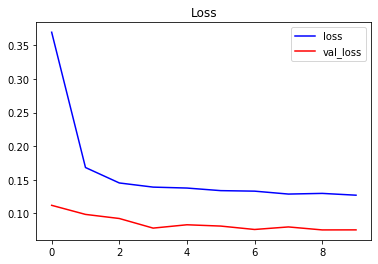

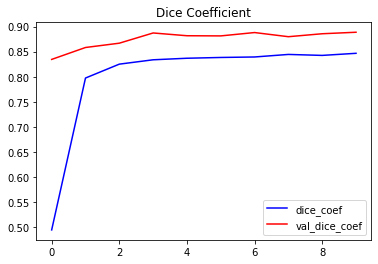

In [29]:
# Plot model performance
model_coord_rot.load_weights('lung_rotated_coordconv.h5')

plt.plot(hist.history['loss'], color='b', label='loss')
plt.plot(hist.history['val_loss'], color='r', label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(hist.history['dice_coef'], color='b', label='dice_coef')
plt.plot(hist.history['val_dice_coef'], color='r', label='val_dice_coef')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

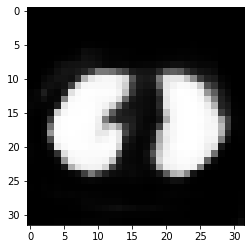

In [30]:
# Show one predicted image
plt.imshow(model_coord_rot.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

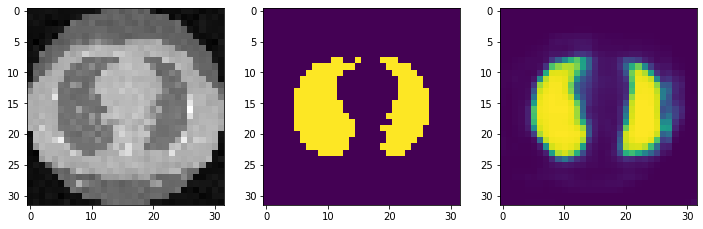

In [31]:
# plot validation and predicted images
y_hat = model_coord_rot.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [32]:
model_coord_rot.evaluate(x_val, y_val)

81/81 [==============================] - 0s 644us/step


[0.11197437695515008, 0.8361702495151095]

### Learnable Rotated CoordConv

Ideally, we want to make the rotation of the CoordConv layer to be a learned parameter, so that the machine can backpropagate to find the best rotation for each image prediction.

We'll accomplish this by using trigonometric functions to transform our CoordConv matrix, setting theta (rotation degree) as our learned parameter.

In [33]:
# Learnable Rotated CoordConv

class CoordConv2D_learned(Layer):
    def __init__(self, channel, kernel, padding='valid',**kwargs):
        self.layer = Conv2D(channel, kernel, padding=padding)
        self.name = 'CoordConv2D_learned'
        super(CoordConv2D_learned, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.theta = tf.Variable(0.0, name='Theta')
        self.trainable_weights = [self.theta]
    
        super(CoordConv2D_learned, self).build(input_shape)
        
    def call(self, input):        
        input_shape = tf.unstack(K.shape(input))
        if K.image_data_format() == 'channel_first':
            bs, channel, w, h = input_shape
        else:
            bs, w, h, channel = input_shape

        # Get indices
        indices = tf.to_float(tf.where(K.ones([bs, w, h])))
        canvas = K.reshape(indices, [bs, w, h, 3])[..., 1:]
        
        # Normalize 
        canvas = canvas / tf.to_float(K.reshape([w, h], [1, 1, 1, 2]))
        canvas_xy = (canvas * 2) - 1
        
        canvas_xy = tf.to_float(canvas_xy)   
        
        # rotate
        base = K.ones([bs, w, h, 1])
        cos_param = K.cos(self.theta)*base
        sin_param = K.sin(self.theta)*base
        x_kernel = K.concatenate([cos_param, -1*sin_param], axis=-1)
        y_kernel = K.concatenate([sin_param, cos_param], axis=-1)
        
        x_rotated = x_kernel*canvas_xy
        y_rotated = y_kernel*canvas_xy
        
        # Concatenate channel-wise
        input = K.concatenate([input, x_rotated, y_rotated], -1)
        
        return self.layer(input)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

In [34]:
input_layer = Input(shape=x_train.shape[1:])
# Apply learned coordconv layer
coordconv_layer = CoordConv2D_learned(64, 3, padding='same')
coord = coordconv_layer(input_layer)
is_weight = Input(shape=(1,), name='is_weight')
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(coord)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model_coord_rot_learned = Model(input_layer, output_layer)

In [35]:
model_coord_rot_learned.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
coord_conv2d_learned_1 (CoordCo (None, 32, 32, 64)   1           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 8)    4616        coord_conv2d_learned_1[0][0]     
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 8)    0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 

In [36]:
# Check learned parameter
model_coord_rot_learned.trainable_weights

[<tf.Variable 'coord_conv2d_learned_1/Theta:0' shape=() dtype=float32_ref>,
 <tf.Variable 'conv2d_31/kernel:0' shape=(3, 3, 64, 8) dtype=float32_ref>,
 <tf.Variable 'conv2d_31/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'conv2d_32/kernel:0' shape=(3, 3, 8, 16) dtype=float32_ref>,
 <tf.Variable 'conv2d_32/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'conv2d_33/kernel:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_33/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_34/kernel:0' shape=(1, 1, 32, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_34/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_35/kernel:0' shape=(2, 2, 64, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_35/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_36/kernel:0' shape=(2, 2, 48, 24) dtype=float32_ref>,
 <tf.Variable 'conv2d_36/bias:0' shape=(24,) dtype=float32_ref>,
 <tf.Variable 'conv2d_37/kernel:0' shape=(2, 2, 32, 16) dtype=float32_ref>,
 <tf.

In [37]:
# Compile and train model
model_coord_rot_learned.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
weight_saver = ModelCheckpoint('lung_rotated_coordconv_learned.h5', monitor='val_dice_coef', 
                               save_best_only=True, save_weights_only=True)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
theta_history = []
class MyCallback(Callback):
    def on_batch_end(self, batch, logs):
        #print(model_coord_rot_learned.layers[1].get_weights()[0])
        theta_history.append(model_coord_rot_learned.layers[1].get_weights()[0])
        


callback = MyCallback()


hist = model_coord_rot_learned.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer, callback])

Epoch 1/10
 - 12s - loss: 0.3454 - dice_coef: 0.5179 - val_loss: 0.1369 - val_dice_coef: 0.7893
Epoch 2/10
 - 8s - loss: 0.1831 - dice_coef: 0.7692 - val_loss: 0.1101 - val_dice_coef: 0.8371
Epoch 3/10
 - 8s - loss: 0.1559 - dice_coef: 0.8071 - val_loss: 0.0987 - val_dice_coef: 0.8567
Epoch 4/10
 - 9s - loss: 0.1474 - dice_coef: 0.8207 - val_loss: 0.0845 - val_dice_coef: 0.8777
Epoch 5/10
 - 8s - loss: 0.1455 - dice_coef: 0.8252 - val_loss: 0.0869 - val_dice_coef: 0.8774
Epoch 6/10
 - 8s - loss: 0.1423 - dice_coef: 0.8280 - val_loss: 0.0849 - val_dice_coef: 0.8776
Epoch 7/10
 - 9s - loss: 0.1413 - dice_coef: 0.8297 - val_loss: 0.0794 - val_dice_coef: 0.8843
Epoch 8/10
 - 9s - loss: 0.1370 - dice_coef: 0.8346 - val_loss: 0.0836 - val_dice_coef: 0.8755
Epoch 9/10
 - 10s - loss: 0.1383 - dice_coef: 0.8332 - val_loss: 0.0787 - val_dice_coef: 0.8816
Epoch 10/10
 - 8s - loss: 0.1322 - dice_coef: 0.8397 - val_loss: 0.0802 - val_dice_coef: 0.8833


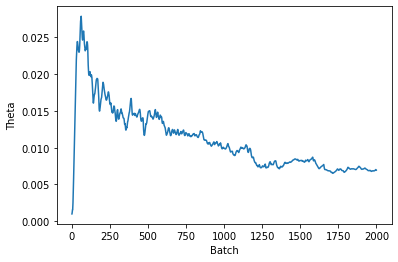

In [38]:
# Plot theta
plt.plot(theta_history)
plt.xlabel('Batch')
plt.ylabel('Theta');

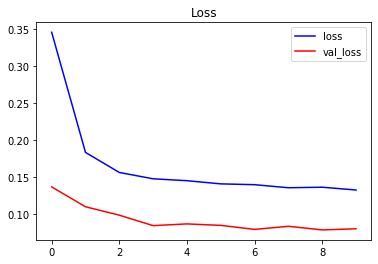

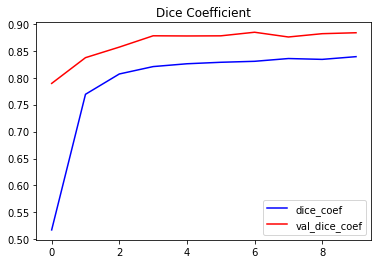

In [39]:
# Plot model performance
model_coord_rot_learned.load_weights('lung_rotated_coordconv_learned.h5')

plt.plot(hist.history['loss'], color='b', label='loss')
plt.plot(hist.history['val_loss'], color='r', label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(hist.history['dice_coef'], color='b', label='dice_coef')
plt.plot(hist.history['val_dice_coef'], color='r', label='val_dice_coef')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

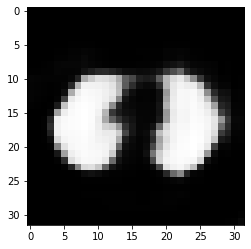

In [40]:
# Show one predicted image
plt.imshow(model_coord_rot_learned.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

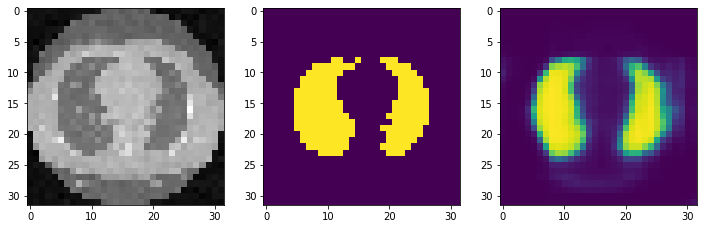

In [41]:
# plot validation and predicted images
y_hat = model_coord_rot_learned.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [42]:
model_coord_rot_learned.evaluate(x_val, y_val)

81/81 [==============================] - 0s 679us/step


[0.13689900916299702, 0.7914177481039071]

## Performance Summary

| Model | Validation Dice Coefficient |
| --- | --- |
| Baseline Model (U-Net) | 0.6088784373836753 |
| CoordConv | 0.8272032642070158 |
| CoordConv (45 Degree Rotation) | 0.8361702495151095 |
| CoordConv (Learned Parameter Rotation) | 0.7914177481039071 |